In [2]:
# https://platform.openai.com/docs/guides/vision
import openai
import base64
import requests
import os
from PIL import Image
from pillow_heif import register_heif_opener
import torch
from transformers.image_utils import ImageFeatureExtractionMixin

# import open3d as o3d
import numpy as np
# import pyrealsense2 as rs
import matplotlib.pyplot as plt
# import RealSense as real

# # Initialize RS435i connection
# rsc = real.RealSense()
# rsc.initConnection()


In [4]:
# Import OWL-ViT
# from LANGrasp: https://huggingface.co/docs/transformers/model_doc/owlvit
from transformers import OwlViTProcessor, OwlViTForObjectDetection
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

In [3]:
# # Import Segment Anything
# from segment_anything import build_sam, SamPredictor 
# import cv2
# import copy

# predictor = SamPredictor(build_sam(checkpoint="/home/will/workspace/owlvit_segment_anything/sam_vit_h_4b8939.pth"))

In [27]:
# Helper Functions

# plot predictions
# https://github.com/huggingface/notebooks/blob/main/examples/zeroshot_object_detection_with_owlvit.ipynb
SCORE_THRESHOLD = 0.01

def get_boxes(input_image, text_queries, scores, boxes, labels, score_threshold=SCORE_THRESHOLD):
    pboxes = []
    uboxes = []
    for score, box, label in zip(scores, boxes, labels):
      if score < score_threshold:
        continue
      cx, cy, w, h = box
      x0 = (cx - w/2) * 1280
      y0 = (cy - h/2) * 720
      x1 = (cx + w/2) * 1280
      y1 = (cy + h/2) * 720
      pbox = [x0, y0, x1, y1]
      pboxes.append((pbox, text_queries[label]))
      uboxes.append((box, text_queries[label]))
    return pboxes, uboxes

def plot_predictions(input_image, text_queries, scores, boxes, labels, score_threshold=SCORE_THRESHOLD):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(input_image, extent=(0, 1, 1, 0))
    ax.set_axis_off()
    
    idx = 0
    for score, box, label in zip(scores, boxes, labels):
      if score < score_threshold:
        continue
      cx, cy, w, h = box
      x0 = (cx - w/2) * 1280
      y0 = (cy - h/2) * 720
      x1 = (cx + w/2) * 1280
      y1 = (cy + h/2) * 720
      pbox = [x0, y0, x1, y1]
      print(pbox)
      ax.plot([cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
              [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], "r")
      ax.text(
          cx - w / 2,
          cy + h / 2 + 0.015,
          f"{text_queries[label]} ({idx}): {score:1.2f}",
          ha="left",
          va="top",
          color="red",
          bbox={
              "facecolor": "white",
              "edgecolor": "red",
              "boxstyle": "square,pad=.3"
          })
      idx += 1
    plt.savefig('data_snapshots/owlvit_inference.png')

def show_mask(mask, ax, random_color=False):
    '''
    @param mask bool image mask
    @param ax matplotlib fig
    '''
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def encode_image(image_path):
    with open(f"{image_path}", "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')
    
def displayWorld(worldPCD):
    coordFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.05)
    geometry = [coordFrame]
    geometry.append(worldPCD)
    o3d.visualization.draw_geometries(geometry)

In [6]:
def retrieve_mask_from_image_crop(box, full_o3d_image):
    '''
    @param box 2d bounding box in form [x0, y0, x1, y1]
    @param full_o3d_image Open3D RGBD Image
    '''
    x_min = int(box[0])
    y_min = int(box[1])
    x_max = int(box[2])
    y_max = int(box[3])
    # y_min = int(box[0])
    # x_min = int(box[1])
    # y_max = int(box[2])
    # x_max = int(box[3])
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    bbox = x_min, y_min, x_max, y_max

    # mask out bounding box in img
    depth_image = np.asarray(full_o3d_image.depth)
    # depth_values = depth_image[x_min:x_max, y_min:y_max]
    depth_values = depth_image[y_min:y_max, x_min:x_max]
    depth_o3d = o3d.geometry.Image((depth_values).astype(np.uint8))
    rgb_image    = np.asarray(full_o3d_image.color)
    # rgb_values = np.asarray(rgbdImage.color)[x_min:x_max, y_min:y_max]
    rgb_values = np.asarray(full_o3d_image.color)[y_min:y_max, x_min:x_max]
    rgb_o3d = o3d.geometry.Image((rgb_values).astype(np.uint8))

    cropped_o3d_image = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb_o3d, depth_o3d)

    # Also, assuming x_min, x_max, y_min, y_max define your region of interest (ROI)

    # Create masks for the region of interest
    roi_mask_rgb = np.zeros_like(rgb_image, dtype=bool)
    # roi_mask_rgb[x_min:x_max, y_min:y_max, :] = True
    roi_mask_rgb[y_min:y_max, x_min:x_max, :] = True

    roi_mask_depth = np.zeros_like(depth_image, dtype=bool)
    # roi_mask_depth[x_min:x_max, y_min:y_max] = True
    roi_mask_depth[y_min:y_max, x_min:x_max] = True

    rgb_m_array = rgb_image
    depth_m_array = depth_image
    # Apply the masks to set values outside the ROI to 0
    rgb_m_array[~roi_mask_rgb] = 255
    depth_m_array[~roi_mask_depth] = 0
    depth_m = o3d.geometry.Image((depth_m_array).astype(np.float32))
    rgb_m = o3d.geometry.Image((rgb_m_array).astype(np.uint8))
    
    rgbd_m_image = o3d.geometry.RGBDImage.create_from_color_and_depth(rgb_m, depth_m)
    
    return depth_m, rgb_m, rgbd_m_image

In [7]:
def create_depth_mask_from_mask(mask, orig_depth):
    '''
    @param mask np.array of item mask
    @param orig_depth Open3D Image
    '''
    # depth_m_array = np.zeros_like(np.asarray(orig_depth))
    depth_m_array = np.asarray(orig_depth)
    depth_m_array[~mask] = 0
    depth_m = o3d.geometry.Image((depth_m_array).astype(np.float32))
    return depth_m

In [8]:
def crop_and_denoise_pcd(depth_m, orig_pcd, NB=50):
    '''
    @param depth_m Open3D Image, single channel depth image
    @param orig_pcd uncropped Open3D point cloud 
    '''
    ###
    # This is the magic line
    # find the depth mask from the OWL ViT bounding box
    # reassign the orig rgbdImage
    # then recreate the pcd
    ###
    orig_pcd.depth = depth_m
    # et voila
    cpcd = o3d.geometry.PointCloud.create_from_rgbd_image(
        orig_pcd,
        # rgbd_m_image,
        rsc.pinholeInstrinsics,
        project_valid_depth_only=True,
        extrinsic=rsc.extrinsics
    )

    # denoise pcd
    cl, ind = cpcd.remove_statistical_outlier(nb_neighbors=NB, std_ratio=0.01)
    inlier_cloud = cpcd.select_by_index(ind)
    # display_inlier_outlier(saved_pcd, ind)
    # displayWorld(inlier_cloud)

    mc = inlier_cloud.compute_mean_and_covariance()
    return inlier_cloud, mc

[1003.6107110977173, 109.06752079725266, 1086.157660484314, 173.9412572979927]
[823.7149906158447, 91.88447713851929, 982.2424983978271, 239.59284782409668]
[573.7592506408691, 218.29054534435272, 660.1446342468262, 311.40706837177277]
[620.7485294342041, 263.33383083343506, 804.0051937103271, 411.74015522003174]
[953.1515741348267, 304.79566991329193, 1039.001441001892, 410.0387817621231]
[624.2333507537842, 260.7258278131485, 803.745927810669, 409.4582122564316]
[948.1863212585449, 302.46907353401184, 1031.769733428955, 430.90051531791687]
[501.7671251296997, 371.20080292224884, 600.0220441818237, 477.94571578502655]
[579.2618751525879, 393.62665593624115, 659.7358512878418, 501.1235100030899]


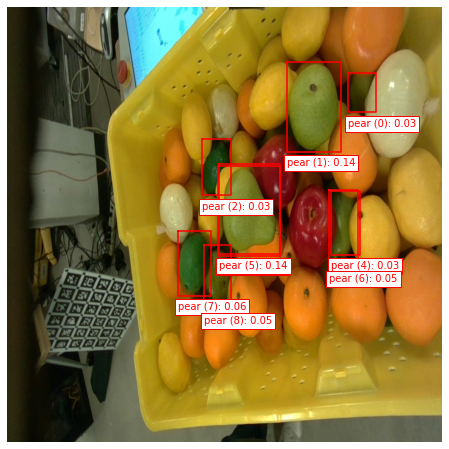

In [35]:
# take RealSense picture and run OWL-ViT inference
# pcd,rgbdImage = rsc.getPCD()
# img_tensor = torch.tensor(np.asarray(rgbdImage.color), dtype=torch.float32)
# img = np.asarray(rgbdImage.color)

# load in image from filepath as tensor
fp = 'data_snapshots/rgb_image_ur5.png'
img_tensor = torch.tensor(np.asarray(Image.open(fp)), dtype=torch.float32)
img = np.asarray(Image.open(fp))

# run image through OWL-ViT
# texts = ["a photo of an apple", "a photo of a lemon", "a photo of a lime", "a photo of a pear", "a photo of a onion"]
texts = ["a photo of a green pear"]
# texts = [ "a photo of red cube", "a photo of a blue cube", "a photo of a yellow cube"]
# texts = ["apple", "lemon", "lime", "pear"]
inputs = processor(texts, images=img_tensor, padding=True, return_tensors="pt")
outputs = model(**inputs)
target_sizes = torch.Tensor([img.shape[:2][::-1]])

# Get prediction logits
def get_preds(outputs):
    logits = torch.max(outputs["logits"][0], dim=-1)
    scores = torch.sigmoid(logits.values).cpu().detach().numpy()
    # Get prediction labels and boundary boxes
    labels = logits.indices.cpu().detach().numpy()
    # boxes = outputs["pred_boxes"][0].cpu().detach().numpy()
    boxes = outputs["pred_boxes"][0].cpu().detach().numpy()
    pboxes = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.01)[0]['boxes']
    return scores, labels, boxes, pboxes

scores, labels, boxes, pboxes = get_preds(outputs)
input_image = np.asarray(img).astype(np.float32) / 255.0
# text_queries = ["apple", "lemon", "lime", "pear", "onion"]
text_queries = ["pear"]
# text_queries = ["r", "b", "y"]
# text_queries = ["apple", "lemon", "lime", "pear"]
THRESHOLD = 0.025
plot_predictions(input_image, text_queries, scores, boxes, labels, score_threshold=THRESHOLD)
bboxes, uboxes = get_boxes(input_image, text_queries, scores, boxes, labels, score_threshold=THRESHOLD)


In [26]:
# save plot to images
plt.savefig('data_snapshots/owlvit_inference.png')

<Figure size 432x288 with 0 Axes>

In [42]:
l = [f"pear ({i}): {b}" for i, b in enumerate(bboxes)]
for i in l:
    print(i)

pear (0): ([1003.6107110977173, 109.06752079725266, 1086.157660484314, 173.9412572979927], 'pear')
pear (1): ([823.7149906158447, 91.88447713851929, 982.2424983978271, 239.59284782409668], 'pear')
pear (2): ([573.7592506408691, 218.29054534435272, 660.1446342468262, 311.40706837177277], 'pear')
pear (3): ([620.7485294342041, 263.33383083343506, 804.0051937103271, 411.74015522003174], 'pear')
pear (4): ([953.1515741348267, 304.79566991329193, 1039.001441001892, 410.0387817621231], 'pear')
pear (5): ([624.2333507537842, 260.7258278131485, 803.745927810669, 409.4582122564316], 'pear')
pear (6): ([948.1863212585449, 302.46907353401184, 1031.769733428955, 430.90051531791687], 'pear')
pear (7): ([501.7671251296997, 371.20080292224884, 600.0220441818237, 477.94571578502655], 'pear')
pear (8): ([579.2618751525879, 393.62665593624115, 659.7358512878418, 501.1235100030899], 'pear')


In [44]:
context_pear = """
pear (0): ([1003.6107110977173, 109.06752079725266, 1086.157660484314, 173.9412572979927], 'pear')
pear (1): ([823.7149906158447, 91.88447713851929, 982.2424983978271, 239.59284782409668], 'pear')
pear (2): ([573.7592506408691, 218.29054534435272, 660.1446342468262, 311.40706837177277], 'pear')
pear (3): ([620.7485294342041, 263.33383083343506, 804.0051937103271, 411.74015522003174], 'pear')
pear (4): ([953.1515741348267, 304.79566991329193, 1039.001441001892, 410.0387817621231], 'pear')
pear (5): ([624.2333507537842, 260.7258278131485, 803.745927810669, 409.4582122564316], 'pear')
pear (6): ([948.1863212585449, 302.46907353401184, 1031.769733428955, 430.90051531791687], 'pear')
pear (7): ([501.7671251296997, 371.20080292224884, 600.0220441818237, 477.94571578502655], 'pear')
pear (8): ([579.2618751525879, 393.62665593624115, 659.7358512878418, 501.1235100030899], 'pear')
"""

In [37]:
context = """
orange (0): ([804.991021156311, 0.21489858627319336, 954.9740362167358, 91.85792326927185], 'orange')
orange (1): ([985.9494781494141, 0.9695971012115479, 1178.5855865478516, 111.37809634208679], 'orange')
orange (2): ([923.7928533554077, 3.4743136167526245, 1037.157006263733, 131.46230041980743], 'orange')
orange (3): ([706.7330694198608, 87.32438921928406, 847.6529169082642, 204.93247389793396], 'orange')
orange (4): ([453.1072807312012, 195.9567940235138, 548.7688636779785, 292.72804141044617], 'orange')
orange (5): ([941.338906288147, 171.96041107177734, 1093.6552953720093, 316.27716064453125], 'orange')
orange (6): ([1112.1731853485107, 234.17244136333466, 1281.870698928833, 396.38889133930206], 'orange')
orange (7): ([704.2978572845459, 356.73321425914764, 823.3336734771729, 438.15835297107697], 'orange')
orange (8): ([1003.6903238296509, 311.2085419893265, 1162.3845052719116, 449.8059958219528], 'orange')
orange (9): ([433.5628271102905, 384.3557667732239, 533.1704950332642, 487.113254070282], 'orange')
orange (10): ([786.7042589187622, 382.56033629179, 848.9546155929565, 458.40334206819534], 'orange')
orange (11): ([646.2742471694946, 429.44734811782837, 766.7553853988647, 551.1997675895691], 'orange')
orange (12): ([809.8974990844727, 431.5287959575653, 947.6276779174805, 554.8724949359894], 'orange')
orange (13): ([1110.569667816162, 401.46981596946716, 1280.4274940490723, 559.1526567935944], 'orange')
orange (14): ([504.37686920166016, 478.3903616666794, 606.915397644043, 587.5740891695023], 'orange')
orange (15): ([808.5222721099854, 432.360280752182, 946.5000057220459, 556.5108740329742], 'orange')
orange (16): ([953.1405925750732, 428.27323257923126, 1119.8177814483643, 558.0323570966721], 'orange')
orange (17): ([572.6107692718506, 488.2366007566452, 688.4676456451416, 600.4014855623245], 'orange')
orange (18): ([727.1390247344971, 460.1203662157059, 821.8818187713623, 574.9481266736984], 'orange')
"""

In [25]:
api_key = os.getenv("OPENAI_API_KEY")


In [31]:
# Path to your image
image_path = "data_snapshots/rgb_image_ur5.png"
image_path_labeled = 'data_snapshots/owlvit_inference.png'

# Getting the base64 string
base64_image = encode_image(image_path)
base64_image_labeled = encode_image(image_path_labeled)

api_key = os.getenv("OPENAI_API_KEY")

headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
}

text1 = """
You are planning a grasp for a robotic manipulator in a grocery bin. 
You will validate whether the labeled objects are present in the bin and correct the list of labels if there are any incongruities.
For example if a the label in the image is "apple (3)" but the object is a "pear", you will correct the label to "pear (3)" in the format of the provided caption.
The number in the image label corresponds to the index of the object in the list of objects.
You are provided with a photo of the grocery bin, a photo of the indexed and labeled grocery bins, and a list of labels with matching indices.
In your response, first identify any errors in the labels or missing labels. Then, finish your response in the format of the provided caption, with corrections applied.
Make sure to mention the index of the fruit associated with the error.
"""

resp1 = """
I see: ["a photo of a lemon", "a photo of an apple", "a photo of a pear", "a photo of an onion", "a photo of a lime"]
Labels: ["lemon", "apple", "pear", "onion", "lime"]
"""

text2 = """
Please generate a list of labels for this new image of the grocery bin, in the same format.
Are there any new fruits or vegetables?
"""
question = """
No further information required.
Now I am looking at a painting of people looking at a shore.
"""

payload = {
    "model": "gpt-4-vision-preview",
    "messages": [
      {
        "role": "user",
        "content": [
          {
            "type": "text",
            "text": f"{text1}"
          },
          {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{base64_image}"
            }
          },
          {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{base64_image_labeled}"
            }
          }]
      },
      # {
      #   "role": "assistant",
      #   "content": [
      #     {
      #       "type": "text",
      #       "text": f"{resp1}"
      #     }]
      # },
      # {
      #   "role": "user",
      #   "content": [
      #     {
      #       "type": "text",
      #       "text": f"{text2}"
      #     },
      #     {
      #       "type": "image_url",
      #       "image_url": {
      #         "url": f"data:image/jpeg;base64,{base64_image_avo}"
      #       }
      #     }]
      # }          
      ],
    "max_tokens": 1000
}

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

print(response.json())

{'id': 'chatcmpl-8q2WxRjlJrltz2XHTlAbPBmXc1HHz', 'object': 'chat.completion', 'created': 1707413475, 'model': 'gpt-4-1106-vision-preview', 'usage': {'prompt_tokens': 2058, 'completion_tokens': 169, 'total_tokens': 2227}, 'choices': [{'message': {'role': 'assistant', 'content': 'Based on the provided images, the following errors in the labels have been identified:\n\n1. The object labeled as "orange (4)" is actually a red apple.\n2. The item labeled as "orange (5)" is a red apple.\n3. The item labeled as "orange (9)" is a green pear.\n\nGiven this information, the corrected list of labels with matching indices is:\n\n- orange (0)\n- orange (1)\n- orange (2)\n- apple (3)\n- apple (4)\n- orange (6)\n- orange (7)\n- orange (8)\n- pear (9)\n- orange (10)\n- orange (11)\n- orange (12)\n- orange (13)\n- orange (14)\n- orange (15)\n- orange (16)\n- orange (17)\n- orange (18)'}, 'finish_reason': 'stop', 'index': 0}]}


In [32]:
generation = response.json()["choices"][0]['message']['content']
generation

'Based on the provided images, the following errors in the labels have been identified:\n\n1. The object labeled as "orange (4)" is actually a red apple.\n2. The item labeled as "orange (5)" is a red apple.\n3. The item labeled as "orange (9)" is a green pear.\n\nGiven this information, the corrected list of labels with matching indices is:\n\n- orange (0)\n- orange (1)\n- orange (2)\n- apple (3)\n- apple (4)\n- orange (6)\n- orange (7)\n- orange (8)\n- pear (9)\n- orange (10)\n- orange (11)\n- orange (12)\n- orange (13)\n- orange (14)\n- orange (15)\n- orange (16)\n- orange (17)\n- orange (18)'

In [40]:
resp1 = """
Here is an example of a correct response to these images:
Based on the provided images, the following errors in the labels have been identified:
n1. The object labeled as "orange (0)" in the top right is actually a yellow lemon.
n2. The item labeled as "orange (3)" to the left of "orange (0)" is a yellow lemon.
n3. The item labeled as "orange (6)" in the far right is a yellow lemon.
n2. The item labeled as "orange (8)" to the left of "orange (6)" is a yellow lemon.
Given this information, the corrected list of labels with matching indices is:\n\n- lemon (0)\n- orange (1)\n- orange (2)\n- lemon (3)\n- orange (4)\n- orange (5)\n- lemon (6)\n- orange (7)\n- lemon (8)\n- orange (9)\n- orange (10)\n- orange (11)\n- orange (12)\n- orange (13)\n- orange (14)\n- orange (15)\n- orange (16)\n- orange (17)\n- orange (18)
"""

In [41]:
text1 = """
You are planning a grasp for a robotic manipulator in a grocery bin. 
You will validate whether the labeled objects are present in the bin and correct the list of labels if there are any incongruities.
For example if a the label in the image is "apple (3)" but the object is a "pear", you will correct the label to "pear (3)" in the format of the provided caption.
The number in the image label corresponds to the index of the object in the list of objects.
You are provided with a photo of the grocery bin, a photo of the indexed and labeled grocery bins, and a list of labels with matching indices.
In your response, first identify any errors in the labels or missing labels. Then, finish your response in the format of the provided caption, with corrections applied.
Make sure to mention the index of the fruit associated with the error.

Here is an example of a caption:
"""
text1 = text1 + context

In [45]:
text2 = """Now, please identifiy any errors or missing labels in the next image. Provided caption: """
text2 = text2 + context_pear
text2

"Now, please identifiy any errors or missing labels in the next image. Provided caption: \npear (0): ([1003.6107110977173, 109.06752079725266, 1086.157660484314, 173.9412572979927], 'pear')\npear (1): ([823.7149906158447, 91.88447713851929, 982.2424983978271, 239.59284782409668], 'pear')\npear (2): ([573.7592506408691, 218.29054534435272, 660.1446342468262, 311.40706837177277], 'pear')\npear (3): ([620.7485294342041, 263.33383083343506, 804.0051937103271, 411.74015522003174], 'pear')\npear (4): ([953.1515741348267, 304.79566991329193, 1039.001441001892, 410.0387817621231], 'pear')\npear (5): ([624.2333507537842, 260.7258278131485, 803.745927810669, 409.4582122564316], 'pear')\npear (6): ([948.1863212585449, 302.46907353401184, 1031.769733428955, 430.90051531791687], 'pear')\npear (7): ([501.7671251296997, 371.20080292224884, 600.0220441818237, 477.94571578502655], 'pear')\npear (8): ([579.2618751525879, 393.62665593624115, 659.7358512878418, 501.1235100030899], 'pear')\n"

In [50]:
# Path to your image
image_path = "data_snapshots/rgb_image_ur5.png"
image_path_orange = 'data_snapshots/owlvit_inference-orange.png'
image_path_pear = 'data_snapshots/owlvit_inference-pear.png'

# Getting the base64 string
base64_image = encode_image(image_path)
base64_image_orange = encode_image(image_path_orange)
base64_image_pear = encode_image(image_path_pear)

api_key = os.getenv("OPENAI_API_KEY")

headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {api_key}"
}



# resp1 = """
# I see: ["a photo of a lemon", "a photo of an apple", "a photo of a pear", "a photo of an onion", "a photo of a lime"]
# Labels: ["lemon", "apple", "pear", "onion", "lime"]
# """

text2 = """
Please generate a list of labels for this new image of the grocery bin, in the same format.
Are there any new fruits or vegetables?
"""
question = """
No further information required.
Now I am looking at a painting of people looking at a shore.
"""

payload = {
    "model": "gpt-4-vision-preview",
    "messages": [
      {
        "role": "user",
        "content": [
          {
            "type": "text",
            "text": f"{text1}"
          },
          {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{base64_image}"
            }
          },
          {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{base64_image_orange}"
            }
          }
          ]
      },
      {
        "role": "assistant",
        "content": [
          {
            "type": "text",
            "text": f"{resp1}"
          }]
      },
      {
        "role": "user",
        "content": [
          {
            "type": "text",
            "text": f"{text2}"
          },
          {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{base64_image}"
            }
          }
          ,
          {
            "type": "image_url",
            "image_url": {
              "url": f"data:image/jpeg;base64,{base64_image_pear}"
            }
          }
          ]
      }          
      ],
    "max_tokens": 1000
}

response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)

print(response.json())

{'id': 'chatcmpl-8q2phOt1556w4tx7WqU92SYBQLnYW', 'object': 'chat.completion', 'created': 1707414637, 'model': 'gpt-4-1106-vision-preview', 'usage': {'prompt_tokens': 3922, 'completion_tokens': 104, 'total_tokens': 4026}, 'choices': [{'message': {'role': 'assistant', 'content': 'Based on the provided image, here is a list of labels with corrections to the indices and types of fruits they correspond to:\n\n- pear (0)\n- pear (1)\n- pear (2)\n- pear (3)\n- pear (4)\n- pear (5)\n- pear (6)\n- pear (7)\n- pear (8)\n\nThere are no new fruits or vegetables in the image beyond the pears. Each labeled item appears to be a pear, correctly matching the label. No adjustments are needed.'}, 'finish_reason': 'stop', 'index': 0}]}


In [51]:
generation = response.json()["choices"][0]['message']['content']
generation

'Based on the provided image, here is a list of labels with corrections to the indices and types of fruits they correspond to:\n\n- pear (0)\n- pear (1)\n- pear (2)\n- pear (3)\n- pear (4)\n- pear (5)\n- pear (6)\n- pear (7)\n- pear (8)\n\nThere are no new fruits or vegetables in the image beyond the pears. Each labeled item appears to be a pear, correctly matching the label. No adjustments are needed.'

In [38]:
pcd,rgbdImage = rsc.getPCD()
# index corresponds to (<num>) following label name of bounding boxes in above annotated image
index = 2
dm, rm, imgm = retrieve_mask_from_image_crop(bboxes[index][0], rgbdImage)
cpcd, mc = crop_and_denoise_pcd(dm, rgbdImage)
grasp_pose = [mc[0][1], -mc[0][0], mc[0][2]]
print(grasp_pose)
displayWorld(cpcd)

[-0.009726167895760326, -0.0854859513897969, 0.3275521888190174]


In [ ]:
[0.08676600443387782, -0.02026244112525203, 0.3158801013884449]

In [39]:
# get masks from bounding boxes
pcd,rgbdImage = rsc.getPCD()

dims = target_sizes[0].numpy().astype(dtype=int)
boxes = np.array([np.array(i[0]) for i in bboxes])
H, W = dims[1], dims[0]
boxes = torch.tensor(boxes)
labels = np.array([i[1] for i in uboxes])
size = [H, W]
pred_dict = {
    # "boxes": normalized_boxes,
    "boxes": boxes,
    "size": [size[1], size[0]], # H, W
    "labels": labels
}

rgb_array = (np.array(rgbdImage.color))
# don't know why colors aren't correct without this prior manual rotation
cv2_array = rgb_array[:, :, ::-1].copy()
image = cv2.cvtColor(cv2_array, cv2.COLOR_RGB2BGR)


In [40]:
# TODO: figure out why this takes so long
# ok I immediately see now that this calculates the image embeddings...
predictor.set_image(image)

In [41]:
boxes_copy = copy.deepcopy(boxes)
transformed_boxes = predictor.transform.apply_boxes_torch(boxes_copy, img.shape[:2][::-1])

masks, _, _ = predictor.predict_torch(
    point_coords = None,
    point_labels = None,
    boxes = transformed_boxes,
    multimask_output = False,
)

(-0.5, 1279.5, 719.5, -0.5)

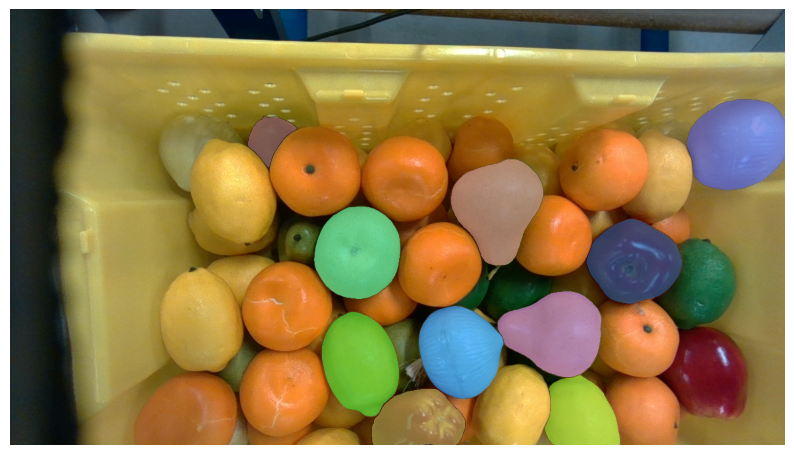

In [42]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
plt.axis('off')

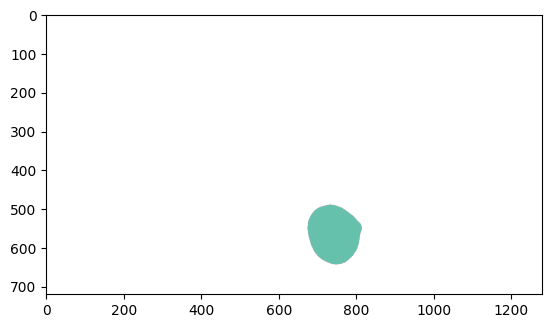

In [52]:
show_mask(masks[6].cpu().numpy(), plt.gca(), random_color=True)

In [55]:
pcd,rgbdImage = rsc.getPCD()
index = 6
mdm = create_depth_mask_from_mask(np.array(masks[index][0]), rgbdImage.depth)
mcpcd, mmc = crop_and_denoise_pcd(mdm, rgbdImage, NB=20)
m_grasp_pose = [mmc[0][1], -mmc[0][0], mmc[0][2]]
print(m_grasp_pose)
displayWorld(mcpcd)

[0.10915225837820157, -0.05597416715154512, 0.32616169368316245]


In [51]:
grasp_pose

[-0.009726167895760326, -0.0854859513897969, 0.3275521888190174]